## Step 1. 导入模块

In [ ]:
import numpy as np
import pandas as pd
from pyecharts import options as opts
from pyecharts.charts import *
from pyecharts.commons.utils import JsCode
from pyecharts.globals import ThemeType
from pyecharts.components import Table
from pyecharts.globals import ChartType
from pyecharts.options import ComponentTitleOpts
from datetime import datetime
import jieba
from stylecloud import gen_stylecloud
from snownlp import SnowNLP
from IPython.display import Image # 用于在jupyter lab中显示本地图片

 ## Step 2. 数据清洗

In [3]:
df1 =pd.read_excel(r"data.xlsx")
df1.head()

,城市,区县,标题,楼盘,区域,总价,单价,户型,面积,朝向,楼层,年份,详情页
0,长沙,长沙周边,"国庆节期间大促,空气清新,通透现房即买即交付 长郡旁,大阳台",绿地21城,株洲-绿地21城,30万,4054元/㎡,2室2厅,74㎡,南北向,高层（共33层）,2018年建,https://cs.esf.fang.com/chushou/3_156857473.htm
1,长沙,长沙周边,"三面花园环绕,地下室和客厅挑空不计面积 大叠墅现房,带电梯",绿地21城别墅,株洲-云水路,135万,8653元/㎡,NaN,156㎡,南向,NaN,NaN,https://cs.esf.fang.com/chushou/10_157624780.htm
2,长沙,长沙周边,"大平层4字头江景美宅,",文博园·碧湖,湘潭-湖南省湘潭市岳塘区沁园路与滨江中路交汇处,67万,4785元/㎡,4室2厅,140㎡,南北向,低层（共29层）,NaN,https://cs.esf.fang.com/chushou/3_157458221.htm
3,长沙,长沙周边,"现房三房,南北通透明厨 首付九万月供一千四百三十七,无需Z格",绿地21城,株洲-云水路与云田路交汇处(方特欢乐世界西侧),41.3万,4089元/㎡,3室2厅,101㎡,南北向,顶层（共32层）,NaN,https://cs.esf.fang.com/chushou/3_157586091.htm
4,长沙,长沙周边,"检漏啦,首付11万买带露台的洋房,长郡旁环境好,南北通透",绿地21城,株洲-云水路与云田路交汇处(方特欢乐世界西侧),54万,5294元/㎡,3室2厅,102㎡,南北向,顶层（共9层）,NaN,https://cs.esf.fang.com/chushou/3_157652300.htm


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9862 entries, 0 to 9861
Data columns (total 13 columns):
城市     9862 non-null object
区县     9862 non-null object
标题     9862 non-null object
楼盘     9862 non-null object
区域     9862 non-null object
总价     9862 non-null object
单价     9862 non-null object
户型     9100 non-null object
面积     9862 non-null object
朝向     9857 non-null object
楼层     9100 non-null object
年份     8184 non-null object
详情页    9862 non-null object
dtypes: object(13)
memory usage: 1001.7+ KB


### 2.1 删除重复值

In [5]:
print(df1.shape)
df1.drop_duplicates(["区县", "标题","楼盘"], inplace=True)
print(df1.shape)

(9862, 13)
(5300, 13)


### 2.2 空值填充

In [6]:
print(np.any(df1.isnull()))
df1.fillna('未知', inplace=True)
print(np.any(df1.isnull()))

True
False


### 2.3 数据转化

In [7]:
df1["总价"] = df1["总价"].apply(lambda x: float(x.replace("万", "")))
df1["单价"] = df1["单价"].apply(lambda x: float(x.replace("元/㎡", "")))
df1["面积"] = df1["面积"].apply(lambda x: float(x.replace("㎡", "")))

### 2.4 重命名列名 

In [8]:
# 重命名列名  
df1 = df1.rename(columns={'面积': '面积(㎡)', '单价': '单价(元/㎡)','总价': '总价(万)'})  

In [9]:
df1.head(3)

,城市,区县,标题,楼盘,区域,总价(万),单价(元/㎡),户型,面积(㎡),朝向,楼层,年份,详情页
0,长沙,长沙周边,"国庆节期间大促,空气清新,通透现房即买即交付 长郡旁,大阳台",绿地21城,株洲-绿地21城,30.0,4054.0,2室2厅,74.0,南北向,高层（共33层）,2018年建,https://cs.esf.fang.com/chushou/3_156857473.htm
1,长沙,长沙周边,"三面花园环绕,地下室和客厅挑空不计面积 大叠墅现房,带电梯",绿地21城别墅,株洲-云水路,135.0,8653.0,未知,156.0,南向,未知,未知,https://cs.esf.fang.com/chushou/10_157624780.htm
2,长沙,长沙周边,"大平层4字头江景美宅,",文博园·碧湖,湘潭-湖南省湘潭市岳塘区沁园路与滨江中路交汇处,67.0,4785.0,4室2厅,140.0,南北向,低层（共29层）,未知,https://cs.esf.fang.com/chushou/3_157458221.htm


 ## Step 3. 数据分析可视化

### 3.1 二手房所属楼盘Top30

In [20]:
area_1 = df1['楼盘'].value_counts()[0:30]
area_1

龙湖·天璞         137
碧桂园威尼斯城别墅      74
时代倾城           62
钰龙天下佳园二期       59
钰龙天下           52
阳光城尚东湾         48
京盛和府           41
旭辉香樟公馆         41
金地都会风华         39
明升壹城           37
丽发新城           36
中建嘉和城          35
恒广国际景园         34
中欣楚天御府         33
万科魅力之城         33
融科东南海          32
绿地新都会          31
旭辉雨金广场         30
北辰中央公园         30
恒基凯旋门          29
江山帝景           29
万科紫台           29
百世云境           28
中国电建湘熙水郡       28
山水芙蓉国际新城别墅     28
华润置地广场         28
保利长交锦上         27
金茂长沙国际社区       27
汉唐·翰林府         26
大都汇天悦          26
Name: 楼盘, dtype: int64

In [21]:

#
bar = Bar(init_opts=opts.InitOpts(width='1000px', height='400px', theme='light',))
bar.add_xaxis(
    area_1.index.tolist()
).add_yaxis(
    '', area_1.tolist(), category_gap='30%'
).set_global_opts(
    title_opts=opts.TitleOpts(
        title="二手房数量Top30的楼盘",  # 标题
        title_textstyle_opts=opts.TextStyleOpts(font_size=20),  # 主标题字体大小
        subtitle="爬取时间：2023-11-02",  # 次坐标轴
        pos_left='center'),  # 标题位置,
    xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(font_size=10, distance=0, rotate=30, color='#4863C4'))
).set_colors('#4863C4')

bar.render_notebook()



![Image Name](https://cdn.kesci.com/upload/s3jfb1dhhl.png?imageView2/0/w/960/h/960)  


**在二手房的所属楼盘中，最多的两个楼盘是龙湖·天璞，超过了100套二手房。**

### 3.2 获取各个价格区间的二手房数量

In [32]:
# 获取各个价格区间的二手房数量
second_price_unit = df1['单价(元/㎡)']
sections = [0, 5000, 6000, 7000, 8000, 9000, 10000, 12000, 15000, 20000, 100000]
group_names = ['<5k', '5k-6k', '6k-7k', '7k-8k', '8k-9k', '9k-1w', '1w-1w2', '1w2-1w5', '1w5-2w', '>2w']
cuts = pd.cut(np.array(second_price_unit), sections, labels=group_names)
second_counts = pd.value_counts(cuts, sort=False)
pie = Pie(init_opts=opts.InitOpts(width='800px', height='600px', bg_color='white'))
pie.add(
    '', [list(z) for z in zip([gen for gen in second_counts.index], second_counts)],
    radius=['20%', '70%'], rosetype="radius", center=['60%', '50%']
).set_series_opts(
label_opts=opts.LabelOpts(formatter='{b}：{c}  {d}%')
).set_global_opts(
    title_opts=opts.TitleOpts(
        title="二手房单价分布情况",  # 标题
        title_textstyle_opts=opts.TextStyleOpts(font_size=20),  # 主标题字体大小
        subtitle="爬取时间：2023-11-02",  # 次坐标轴
        pos_left='center', pos_top='20',),  # 标题位置,
    legend_opts=opts.LegendOpts(is_show=False)
).set_colors(
    ['rgb(0,{g},{b})'.format(g=100+10*x, b=200-15*x) for x in range(12)])
pie.render_notebook()


![Image Name](https://cdn.kesci.com/upload/s3jfbhjnfq.png?imageView2/0/w/960/h/960)  


**从单价看，大部分二手房的单价在1万-1万5之间，如果按1000来切分最多的是9千~1万，**

### 3.3 获取二手房总价各区间的数量

In [34]:


# 获取二手房总价各区间的数量
second_price_total = df1['总价(万)']
sections = [0, 50, 60, 70, 80, 90, 100, 120, 150, 200, 250, 10000]
group_names = ['<50w', '50w-60w', '60w-70w', '70w-80w', '80w-90w', '90w-100w', '100w-120w', '120w-150w', '150w-200w', '200w-250w', '>250w']
cuts = pd.cut(np.array(second_price_total), sections, labels=group_names)
second_counts = pd.value_counts(cuts)
pie = Pie(init_opts=opts.InitOpts(width='800px', height='600px', bg_color='white'))
pie.add(
    '', [list(z) for z in zip([gen for gen in second_counts.index], second_counts)],
    radius=['20%', '70%'], rosetype="radius", center=['50%', '50%']
).set_series_opts(
    label_opts=opts.LabelOpts(formatter='{b}：{c}  {d}%')
).set_global_opts(
    title_opts=opts.TitleOpts(
        title="二手房总价分布情况",  # 标题
        title_textstyle_opts=opts.TextStyleOpts(font_size=20),  # 主标题字体大小
        subtitle="爬取时间：2023-11-02",  # 次坐标轴
        pos_left='center', pos_top='10',),  # 标题位置,
    legend_opts=opts.LegendOpts(is_show=False)
).set_colors(
    ['rgb(0,{g},{b})'.format(g=100+10*x, b=200-15*x) for x in range(12)]
).render_notebook()



![Image Name](https://cdn.kesci.com/upload/s3jfbu3fhg.png?imageView2/0/w/960/h/960)  


### 3.4 二手房户型分布

In [35]:

# 获取二手房的户型分布
second_house_type = df1['户型'].value_counts()
unknown = second_house_type['未知']
second_house_type.drop('未知', inplace=True)
second_house_type_parse = second_house_type.loc[second_house_type >= 10]
second_house_type_parse['others'] = second_house_type.loc[second_house_type < 10].sum()
second_house_type_parse['未知'] = unknown
bar = Bar(init_opts=opts.InitOpts(width='1000px', height='400px',  theme='light'))
bar.add_xaxis(
    second_house_type_parse.index.to_list()
).add_yaxis(
    '', second_house_type_parse.to_list(), category_gap='30%'
).set_global_opts(
    title_opts=opts.TitleOpts(
        title="二手房户型数量分布",  # 标题
        title_textstyle_opts=opts.TextStyleOpts(font_size=20),  # 主标题字体大小
        subtitle="爬取时间：2023-11-02",  # 次坐标轴
        pos_left='center', pos_top='10',),  # 标题位置,
    xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(font_size=12, distance=0, rotate=20)),
    yaxis_opts=opts.AxisOpts()
).render_notebook()



![Image Name](https://cdn.kesci.com/upload/s3jfc6ia0x.png?imageView2/0/w/960/h/960)  


### 3.5 获取二手房的面积分布情况

In [40]:
# 获取二手房的面积分布情况
df_second = df1.drop(df1.loc[df1['面积(㎡)']=='未知'].index)
second_area = df_second['面积(㎡)'].copy()
sections = [0, 50, 80, 90, 100, 110, 120, 130, 140, 150, 200, 10000]
group_names = ['<50㎡', '50-80㎡', '80-90㎡', '90-100㎡', '100-110㎡', '110-120㎡', '120-130㎡', '130-140㎡', '140-150㎡', '150-200㎡', '>200㎡']
cuts = pd.cut(np.array(second_area), sections, labels=group_names)
second_area_counts = pd.value_counts(cuts, ascending=True)
pie = Pie(init_opts=opts.InitOpts(width='800px', height='600px', bg_color='white'))
pie.add(
    '', [list(z) for z in zip([gen for gen in second_area_counts.index], second_area_counts)],
    radius=['20%', '70%'], rosetype="radius", center=['50%', '50%']
).set_series_opts(
    label_opts=opts.LabelOpts(formatter="{b}: {c}"),
).set_global_opts(
    title_opts=opts.TitleOpts(
        title="二手房面积分布情况",  # 标题
        title_textstyle_opts=opts.TextStyleOpts(font_size=20),  # 主标题字体大小
        subtitle="爬取时间：2023-11-02",  # 次坐标轴
        pos_left='center', pos_top='10',),  # 标题位置,
    legend_opts=opts.LegendOpts(is_show=False)
).set_colors(
    ['rgb({r},0,{b})'.format(r=20*x, b=250-15*x) for x in range(12)]
).render_notebook()


![Image Name](https://cdn.kesci.com/upload/s3jfcih9h0.png?imageView2/0/w/960/h/960)  


### 3.6 二手房朝向分布情况

In [39]:

second_house_toward = df1['朝向'].value_counts()
pie = Pie(init_opts=opts.InitOpts(width='800px', height='600px', theme='light'))
pie.add(
    '', [list(z) for z in zip([gen for gen in second_house_toward.index], second_house_toward)],
    radius=['40%', '60%'], center=['50%', '50%']
).set_series_opts(
    label_opts=opts.LabelOpts(formatter="{b}: {c}"),
).set_global_opts(
    title_opts=opts.TitleOpts(
        title="二手房朝向分布情况",  # 标题
        title_textstyle_opts=opts.TextStyleOpts(font_size=20),  # 主标题字体大小
        subtitle="爬取时间：2023-11-02",  # 次坐标轴
        pos_left='center', pos_top='10',),  # 标题位置,
    legend_opts=opts.LegendOpts(is_show=False)
).render_notebook()



![Image Name](https://cdn.kesci.com/upload/s3jfcu3s6z.png?imageView2/0/w/960/h/960)  


### 3.7 二手房的修建年份

In [18]:
second_house_build_year = df1['年份'].copy().value_counts()
second_house_build_year

2018年建    1045
未知        1043
2023年建     666
2022年建     472
2017年建     311
2016年建     276
2014年建     245
2015年建     219
2013年建     174
2021年建     173
2020年建     158
2012年建     138
2019年建      98
2010年建      74
2011年建      46
2024年建      38
2008年建      37
2009年建      18
2006年建      16
2000年建      14
2007年建      12
2004年建       9
2005年建       4
2002年建       4
2003年建       3
2025年建       2
1998年建       2
1999年建       1
2001年建       1
1996年建       1
Name: 年份, dtype: int64

In [41]:

# 获取二手房的修建年份
second_house_build_year = df1['年份'].copy().value_counts()
second_house_build_year.index = [y[0:4] for y in second_house_build_year.index.to_list()]
second_house_build_year = second_house_build_year.sort_index(ascending=False)
bar = Bar(init_opts=opts.InitOpts(width='1000px', height='400px', bg_color='white'))
bar.add_xaxis([i for i in second_house_build_year.index]).add_yaxis(
    '', second_house_build_year.to_list(), category_gap='20%'
).set_series_opts(
    label_opts=opts.LabelOpts(font_size=12)
).set_global_opts(
    title_opts=opts.TitleOpts(
        title="二手房修建年份分布",  # 标题
        title_textstyle_opts=opts.TextStyleOpts(font_size=20),  # 主标题字体大小
        subtitle="爬取时间：2023-11-02",  # 次坐标轴
        pos_left='center', pos_top='10',),  # 标题位置,
    yaxis_opts=opts.AxisOpts(),
    xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(font_size=10, rotate=30, interval=0, color='#4863C4'))
).set_colors(['#4863C4']).render_notebook()



![Image Name](https://cdn.kesci.com/upload/s3jfd7xcpq.png?imageView2/0/w/960/h/960)  


### 3.8 二手房信息的标题风格 

In [47]:
second_house_title = df1['标题']
title_content = ','.join([str(til.replace(' ', '')) for til in second_house_title.to_list()])
cut_text = jieba.cut(title_content)
result = ' '.join(cut_text)
result

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\H1638\AppData\Local\Temp\jieba.cache
Loading model cost 0.902 seconds.
Prefix dict has been built successfully.


'国庆节 期间 大促 , 空气清新 , 通透 现房 即 买 即 交付 长郡 旁 , 大 阳台 , 三面 花园 环绕 , 地下室 和 客厅 挑空 不计 面积 大叠 墅 现房 , 带 电梯 , 大平 层 4 字头 江景 美宅 , , 现房 三房 , 南北 通 透明 厨 首付 九万 月 供 一千四百 三十七 , 无需 Z 格 , 检漏 啦 , 首付 11 万买 带 露台 的 洋房 , 长郡 旁 环境 好 , 南北 通透 , 总价 58 万买长 郡 旁 首付 12 万 , 三面 采光 南向 阳台 12 米 无需 Z 格 , 独户 电梯 , 一户 一 整层 , 带二边 大 露台 和 阁楼 无需 购房 Z 格 , 无需 z 格 , 洋房 , 纯板楼 , 南北 通透 双大 阳台 , 部分 一楼 带 花园 , 首付 20 万买 大平 层 现房 洋房 独户 电梯 送二边 大 露台 带阁楼 , 均价 5600 高铁 口 长沙 三号 线 无需 购房 新房 免佣 , 现房 下叠 边户 , 带 院子 和 露台 及 全明 架空层 南北 通 透明 厨明卫 可拓 , 长沙 南 无需 购房 z 格 电梯 房 直接 认购 首付 十万 长郡 旁 环境 好 , 无需 Z 格 三层 上叠 带阁楼 和 大 露台 及 客厅 挑空 不计 面积 可 眺望 星空 , 首付 22 万起 买 三层 下叠 , 带前 后花园 , 架空层 及 客厅 挑空 不计 面积 , 首付 18 万起 买 上 叠 , 带 大 露台 和 阁楼 , 带 电梯 总价 仅 90 万起 , 现房 带阁楼 和 大 露台 , 视野 开阔 可 眺望 星空 采光 通风 很 好 , 厨房 可拓 , 三层 上叠 现房 带阁楼 和 露台 及 客厅 挑空 不计 面积 可 眺望 星空 和 远景 , 准现房 , 纯板楼 花园 洋房 南北 通透 边户 带 二个 大 阳台 电梯 入户 , 有天 有 地 才 是 真 别墅 部分 可 看江 , 通透 二房 首付 6 万月供 约 1050 , 长郡 旁明 厨明 卫带 大 阳台 , 长郡 旁四房 二厅 二卫 双阳台 南北 通透 三面 采光 无需 购房 z 格 , 首付 21 万起 买 5 层 双拼 别墅 有天 有 地 , 带 大 花园 和 露台 及 地下室 , 一期 现房 叠墅 客厅 挑空 , 带 南北 双 花园 , 地下室 , 无

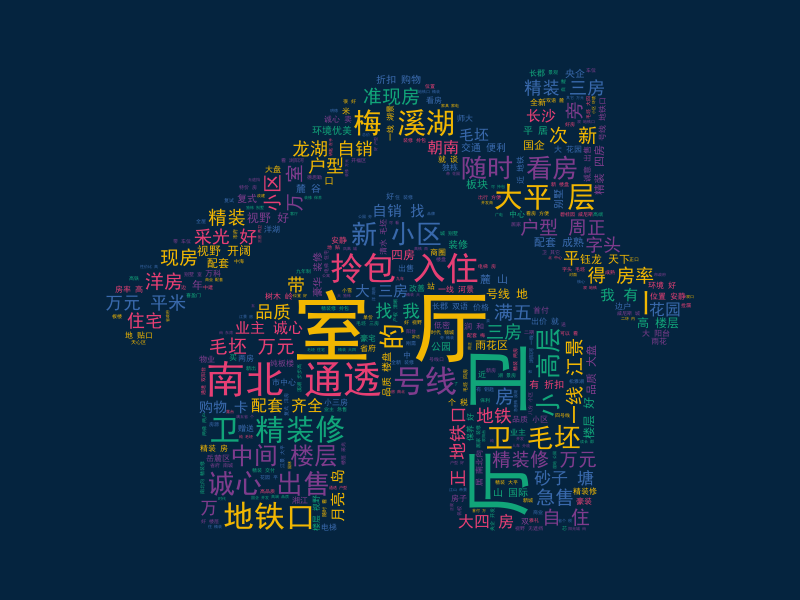

In [50]:

exclude = []
gen_stylecloud(
    text=result, size=(800, 600), max_words=500, max_font_size=80, font_path='simhei.ttf',
    icon_name='fas fa-home', output_name='top20.png',
    background_color='#05243F', custom_stopwords=exclude,
)
Image(filename='top20.png')